In [1]:
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

sns.set()
sns.set_style("ticks")
sns.set_context("paper", font_scale = 1.8)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 25

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import functional as F
from torch.nn import init
from torch.nn import Module
import FrEIA.framework as Ff
import FrEIA.modules as Fm
from sklearn.model_selection import train_test_split

print('Python', sys.version)

Python 3.9.12 (main, Apr  5 2022, 01:53:17) 
[Clang 12.0.0 ]


In [2]:
class dalitz_dataset(Dataset):
    """
    Creates Dalitz dataset so that it can be used by the pythorch syntax.
    """

    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        sample = self.data[idx]
        return sample

In [5]:
class Linear_VB(Module):
    """
    Build a Bayesian linear weight layer i.e. weights are now distributions
    """
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor
    
    def __init__(self, in_features, out_features, resample = True):
        super(Linear_VB, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.resample = resample                                        # Sample random weights through each forward pass
        self.bias = Parameter(Tensor(out_features))                     # Assign as tunable parameter with dimension (1 x out_features)
        self.mu_w = Parameter(Tensor(out_features, in_features))        # Assign as tunable parameter with dimension (out_features x in_features)
        self.logsig2_w = Parameter(Tensor(out_features, in_features))   # Assign as tunable parameter with dimension (out_features x in_features)
        self.random = torch.randn_like(self.logsig2_w)
        self.reset_parameters()
        
    def forward( self, input ):
        # Sample random weights on each forward pass
        if self.resample:
            self.random = torch.randn_like(self.logsig2_w)
        s2_w = self.logsig2_w.exp()
        # Reparameterization trick
        weight = self.mu_w + s2_w.sqrt() * self.random
        return nn.functional.linear(input, weight, self.bias)
    
    def reset_parameters(self):
        stdv = 1. / np.sqrt(self.mu_w.size(1))
        self.mu_w.data.normal_(0, stdv)
        self.logsig2_w.data.zero_().normal_(-9, 0.001)
        self.bias.data.zero_()
        
    def KL( self, loguniform=False ):
        kl = 0.5 * (self.mu_w.pow(2) + self.logsig2_w.exp() - self.logsig2_w - 1).sum()
        return kl

In [7]:
class Bayes_INN(Module):
    def __init__(self, n_dim, training_size, input_dim = 2000, hidden_dim = 2000, output_dim = 2000, resample = True):
        super(Bayes_INN, self).__init__()

        # Number of entries in the training dataset
        self.n_dim = n_dim
        
        # Loss function is dependent on the size of the training dataset
        self.training_size = training_size

        def subnet(input_dim, output_dim):

            # Two types of layers -> weight layers and activation layers the latter is not Bayesian
            self.subnet_bayes_layers = []
            self.subnet_layers       = []
    
            # Define the input layer
            linear_VB_layer = Linear_VB(input_dim, hidden_dim)#, resample = resample)
            self.subnet_bayes_layers.append(linear_VB_layer)
            self.subnet_layers.append(linear_VB_layer)
            self.subnet_layers.append(nn.ReLU())
    
            # If you want a more complex subnet, add more hidden layers
            linear_VB_layer = Linear_VB(hidden_dim, hidden_dim)
            self.subnet_bayes_layers.append(linear_VB_layer)
            self.subnet_layers.append(linear_VB_layer)
            self.subnet_layers.append(nn.ReLU())
    
            # Now for the final output layer
            linear_VB_layer = Linear_VB(hidden_dim, output_dim)#, resample = resample)
            self.subnet_bayes_layers.append(linear_VB_layer)
            self.subnet_layers.append(linear_VB_layer)
            # We don't need an activation layer for the output layer
    
            # The full model is a sequentiual net over the defined layers above
            return nn.Sequential(*self.subnet_layers)


        self.inn = Ff.SequenceINN(self.n_dim)
        for k in range(self.n_dim):
            self.inn.append(Fm.AllInOneBlock, subnet_constructor=subnet, permute_soft=True)
            #self.inn.append(Fm.GINCouplingBlock, subnet_constructor=subnet)

    # We need the KL from the Bayesian layers
    def KL(self):
        kl = 0
        for bayesian_layer in self.subnet_bayes_layers:
            kl += bayesian_layer.KL()
        return kl / self.training_size # Normalized to the training size? 

In [10]:
def inn_loss(z, ndim, log_jac_det):
    l = 0.5*torch.sum(z**2, 1) - log_jac_det
    l = l.mean() / ndim
    return l

In [11]:
def train(dataloader, model, optimizer, scheduler=None, ndim = 5):

    size = len(dataloader.dataset)
    model.train()

    for batch, X in enumerate(dataloader):
        # Pass through the network
        z, log_jac_det = model(X)
        
        loss_inn, loss_KL, loss = 0.0, 0.0, 0.0
        
        # Compute the KL loss for each of the Bayesian layers in the network
        for i in range(len(model.module_list)):
            for j in [0,2,4]:
                loss_KL += model.module_list[i].subnet[j].KL()
        loss_KL = loss_KL / size
        loss_KL = 0
        #print(loss_KL)
        #print(BINN.KL())

        # Get the batch loss
        loss_inn = inn_loss(z, ndim, log_jac_det)
        
        loss = loss_KL + loss_inn
        
        # Also need to include KL loss for tuning stochastic layer weights

        # Reset the gradients in the optimizer (see autograd tutorial in PyTorch docs)
        optimizer.zero_grad()

        # Compute gradients
        loss.backward()

        # Update the network weights
        optimizer.step()
        
        if scheduler != None:
            scheduler.step(loss)

        # Print the loss every 100 updates
        if batch % 100 == 0:
            print(f'Total loss: {loss:>8f} INN loss: {loss_inn:>8f} KL loss: {loss_KL:>8f} learning_rate: {optimizer.param_groups[0]["lr"]:>8f}')

In [12]:
mp_thetap = np.load('D_Kspipi_SDP_1e7.npy')

# Split data into train, validation
mp_thetap_train, mp_thetap_val = train_test_split(mp_thetap, test_size=0.2)

print("Training set size: ", mp_thetap_train.shape, "Validation set size: ", mp_thetap_val.shape)

# Convert into torch objects
mp_thetap_train = torch.Tensor(mp_thetap_train)
mp_thetap_val   = torch.Tensor(mp_thetap_val)

trainset = dalitz_dataset(mp_thetap_train)
valset   = dalitz_dataset(mp_thetap_val)

batch_size = 500

train_dataloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(valset, batch_size = batch_size, shuffle = True)

epochs = 50
learning_rate = 0.001

n_dim = mp_thetap.shape[1]
input_dim = 1           # One value of mp or thetap
hidden_dim = 50         # Subnetwork hidden layers
output_dim = 1          # One value out for generated mp or thetap
training_size = len(mp_thetap)
resample = False

# Define the model
BINN = Bayes_INN(n_dim = n_dim, training_size = training_size, input_dim = input_dim, hidden_dim = hidden_dim, output_dim = output_dim, resample = resample)
model = BINN.inn

print("Model Architecture: ")
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode= 'min', factor = 0.9, patience = 50)
#scheduler = None

for t in tqdm(range(epochs), ncols = 100):
    train(train_dataloader, model, optimizer, scheduler, n_dim)
    
print("Done!")

Training set size:  (8000000, 2) Validation set size:  (2000000, 2)
Model Architecture: 
SequenceINN(
  (module_list): ModuleList(
    (0-1): 2 x AllInOneBlock(
      (softplus): Softplus(beta=0.5, threshold=20)
      (subnet): Sequential(
        (0): Linear_VB()
        (1): ReLU()
        (2): Linear_VB()
        (3): ReLU()
        (4): Linear_VB()
      )
    )
  )
)


  0%|                                                                        | 0/50 [00:00<?, ?it/s]

Total loss: 0.144088 INN loss: 0.144088 KL loss: 0.000000 learning_rate: 0.001000
Total loss: -0.659813 INN loss: -0.659813 KL loss: 0.000000 learning_rate: 0.001000
Total loss: -0.994354 INN loss: -0.994354 KL loss: 0.000000 learning_rate: 0.001000
Total loss: -1.047382 INN loss: -1.047382 KL loss: 0.000000 learning_rate: 0.001000
Total loss: -1.101462 INN loss: -1.101462 KL loss: 0.000000 learning_rate: 0.000900
Total loss: -1.099162 INN loss: -1.099162 KL loss: 0.000000 learning_rate: 0.000729
Total loss: -1.095482 INN loss: -1.095482 KL loss: 0.000000 learning_rate: 0.000729
Total loss: -1.118851 INN loss: -1.118851 KL loss: 0.000000 learning_rate: 0.000590
Total loss: -1.082161 INN loss: -1.082161 KL loss: 0.000000 learning_rate: 0.000478
Total loss: -1.100653 INN loss: -1.100653 KL loss: 0.000000 learning_rate: 0.000430
Total loss: -1.200483 INN loss: -1.200483 KL loss: 0.000000 learning_rate: 0.000387
Total loss: -1.110767 INN loss: -1.110767 KL loss: 0.000000 learning_rate: 0.0

  2%|█▏                                                           | 1/50 [02:36<2:08:02, 156.78s/it]

Total loss: -1.113629 INN loss: -1.113629 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.127314 INN loss: -1.127314 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.116505 INN loss: -1.116505 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.109666 INN loss: -1.109666 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.149641 INN loss: -1.149641 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.114667 INN loss: -1.114667 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.092467 INN loss: -1.092467 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.136652 INN loss: -1.136652 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.182651 INN loss: -1.182651 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.154541 INN loss: -1.154541 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.080443 INN loss: -1.080443 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.109848 INN loss: -1.109848 KL loss: 0.000000 learning_rate: 0

  4%|██▍                                                          | 2/50 [04:59<1:59:02, 148.80s/it]

Total loss: -1.129763 INN loss: -1.129763 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.172547 INN loss: -1.172547 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.129425 INN loss: -1.129425 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.121994 INN loss: -1.121994 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.136657 INN loss: -1.136657 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.143454 INN loss: -1.143454 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.128563 INN loss: -1.128563 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.126937 INN loss: -1.126937 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.168151 INN loss: -1.168151 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.124022 INN loss: -1.124022 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.153741 INN loss: -1.153741 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.126625 INN loss: -1.126625 KL loss: 0.000000 learning_rate: 0

  6%|███▍                                                     | 3/50 [1:03:05<21:50:08, 1672.52s/it]

Total loss: -1.112983 INN loss: -1.112983 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.112415 INN loss: -1.112415 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.165071 INN loss: -1.165071 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.115806 INN loss: -1.115806 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.104970 INN loss: -1.104970 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.147402 INN loss: -1.147402 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.179481 INN loss: -1.179481 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.125193 INN loss: -1.125193 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.155821 INN loss: -1.155821 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.114427 INN loss: -1.114427 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.150330 INN loss: -1.150330 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.130760 INN loss: -1.130760 KL loss: 0.000000 learning_rate: 0

  8%|████▌                                                    | 4/50 [3:25:31<56:02:40, 4386.11s/it]

Total loss: -1.135931 INN loss: -1.135931 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.062947 INN loss: -1.062947 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.170216 INN loss: -1.170216 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.104859 INN loss: -1.104859 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.136040 INN loss: -1.136040 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.120207 INN loss: -1.120207 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.133709 INN loss: -1.133709 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.132160 INN loss: -1.132160 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.110609 INN loss: -1.110609 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.150637 INN loss: -1.150637 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.121361 INN loss: -1.121361 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.137344 INN loss: -1.137344 KL loss: 0.000000 learning_rate: 0

 10%|█████▋                                                   | 5/50 [3:27:47<35:40:03, 2853.40s/it]

Total loss: -1.140640 INN loss: -1.140640 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.110045 INN loss: -1.110045 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.152180 INN loss: -1.152180 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.109518 INN loss: -1.109518 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.128384 INN loss: -1.128384 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.107267 INN loss: -1.107267 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.126180 INN loss: -1.126180 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.148946 INN loss: -1.148946 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.100079 INN loss: -1.100079 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.200029 INN loss: -1.200029 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.100299 INN loss: -1.100299 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.149154 INN loss: -1.149154 KL loss: 0.000000 learning_rate: 0

 12%|██████▊                                                  | 6/50 [3:29:28<23:26:14, 1917.59s/it]

Total loss: -1.150535 INN loss: -1.150535 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.146159 INN loss: -1.146159 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.115935 INN loss: -1.115935 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.123658 INN loss: -1.123658 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.080589 INN loss: -1.080589 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.118145 INN loss: -1.118145 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.121377 INN loss: -1.121377 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.099759 INN loss: -1.099759 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.134524 INN loss: -1.134524 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.168497 INN loss: -1.168497 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.133780 INN loss: -1.133780 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.130876 INN loss: -1.130876 KL loss: 0.000000 learning_rate: 0

 14%|███████▉                                                 | 7/50 [3:31:06<15:47:52, 1322.62s/it]

Total loss: -1.124214 INN loss: -1.124214 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.095955 INN loss: -1.095955 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.168688 INN loss: -1.168688 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.096100 INN loss: -1.096100 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.115458 INN loss: -1.115458 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.107220 INN loss: -1.107220 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.148722 INN loss: -1.148722 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.152256 INN loss: -1.152256 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.125891 INN loss: -1.125891 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.109837 INN loss: -1.109837 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.177379 INN loss: -1.177379 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.138601 INN loss: -1.138601 KL loss: 0.000000 learning_rate: 0

 16%|█████████▎                                                | 8/50 [3:35:04<11:24:10, 977.38s/it]

Total loss: -1.101491 INN loss: -1.101491 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.130812 INN loss: -1.130812 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.089200 INN loss: -1.089200 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.157317 INN loss: -1.157317 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.105517 INN loss: -1.105517 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.099196 INN loss: -1.099196 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.137061 INN loss: -1.137061 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.101036 INN loss: -1.101036 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.091969 INN loss: -1.091969 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.121720 INN loss: -1.121720 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.140309 INN loss: -1.140309 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.116481 INN loss: -1.116481 KL loss: 0.000000 learning_rate: 0

 18%|██████████▌                                                | 9/50 [3:36:37<7:58:53, 700.81s/it]

Total loss: -1.136236 INN loss: -1.136236 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.128464 INN loss: -1.128464 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.077549 INN loss: -1.077549 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.134100 INN loss: -1.134100 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.119265 INN loss: -1.119265 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.146740 INN loss: -1.146740 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.114442 INN loss: -1.114442 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.136954 INN loss: -1.136954 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.117861 INN loss: -1.117861 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.127450 INN loss: -1.127450 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.155648 INN loss: -1.155648 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.145690 INN loss: -1.145690 KL loss: 0.000000 learning_rate: 0

 20%|███████████▌                                              | 10/50 [3:38:13<5:42:50, 514.27s/it]

Total loss: -1.094639 INN loss: -1.094639 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.151922 INN loss: -1.151922 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.115103 INN loss: -1.115103 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.108470 INN loss: -1.108470 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.115472 INN loss: -1.115472 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.146435 INN loss: -1.146435 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.144114 INN loss: -1.144114 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.078470 INN loss: -1.078470 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.157402 INN loss: -1.157402 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.157355 INN loss: -1.157355 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.110453 INN loss: -1.110453 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.133651 INN loss: -1.133651 KL loss: 0.000000 learning_rate: 0

 22%|████████████▊                                             | 11/50 [3:39:43<4:09:48, 384.31s/it]

Total loss: -1.179374 INN loss: -1.179374 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.152563 INN loss: -1.152563 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.116653 INN loss: -1.116653 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.130381 INN loss: -1.130381 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.170301 INN loss: -1.170301 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.163924 INN loss: -1.163924 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.141886 INN loss: -1.141886 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.126501 INN loss: -1.126501 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.145631 INN loss: -1.145631 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.207391 INN loss: -1.207391 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.174739 INN loss: -1.174739 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.155004 INN loss: -1.155004 KL loss: 0.000000 learning_rate: 0

 24%|█████████████▉                                            | 12/50 [3:41:18<3:07:38, 296.29s/it]

Total loss: -1.123788 INN loss: -1.123788 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.160603 INN loss: -1.160603 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.090775 INN loss: -1.090775 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.135547 INN loss: -1.135547 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.135615 INN loss: -1.135615 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.166427 INN loss: -1.166427 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.106878 INN loss: -1.106878 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.137871 INN loss: -1.137871 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.158616 INN loss: -1.158616 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.113777 INN loss: -1.113777 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.121953 INN loss: -1.121953 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.125604 INN loss: -1.125604 KL loss: 0.000000 learning_rate: 0

 26%|███████████████                                           | 13/50 [3:42:52<2:24:57, 235.06s/it]

Total loss: -1.147757 INN loss: -1.147757 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.110939 INN loss: -1.110939 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.124476 INN loss: -1.124476 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.094039 INN loss: -1.094039 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.080267 INN loss: -1.080267 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.147102 INN loss: -1.147102 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.121936 INN loss: -1.121936 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.142978 INN loss: -1.142978 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.163683 INN loss: -1.163683 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.138862 INN loss: -1.138862 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.099679 INN loss: -1.099679 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.164658 INN loss: -1.164658 KL loss: 0.000000 learning_rate: 0

 28%|████████████████▏                                         | 14/50 [3:44:26<1:55:32, 192.56s/it]

Total loss: -1.172694 INN loss: -1.172694 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.163805 INN loss: -1.163805 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.099692 INN loss: -1.099692 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.141495 INN loss: -1.141495 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.119047 INN loss: -1.119047 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.133466 INN loss: -1.133466 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.097425 INN loss: -1.097425 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.153008 INN loss: -1.153008 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.100756 INN loss: -1.100756 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.205914 INN loss: -1.205914 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.108295 INN loss: -1.108295 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.114806 INN loss: -1.114806 KL loss: 0.000000 learning_rate: 0

 30%|█████████████████▍                                        | 15/50 [3:45:58<1:34:40, 162.30s/it]

Total loss: -1.151726 INN loss: -1.151726 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.132266 INN loss: -1.132266 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.171904 INN loss: -1.171904 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.139307 INN loss: -1.139307 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.167046 INN loss: -1.167046 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.149006 INN loss: -1.149006 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.116675 INN loss: -1.116675 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.109618 INN loss: -1.109618 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.079837 INN loss: -1.079837 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.170837 INN loss: -1.170837 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.172614 INN loss: -1.172614 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.092996 INN loss: -1.092996 KL loss: 0.000000 learning_rate: 0

 32%|██████████████████▌                                       | 16/50 [3:47:34<1:20:39, 142.33s/it]

Total loss: -1.120996 INN loss: -1.120996 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.191369 INN loss: -1.191369 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.137040 INN loss: -1.137040 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.127805 INN loss: -1.127805 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.142655 INN loss: -1.142655 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.116683 INN loss: -1.116683 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.134810 INN loss: -1.134810 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.076316 INN loss: -1.076316 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.138204 INN loss: -1.138204 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.120741 INN loss: -1.120741 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.144000 INN loss: -1.144000 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.101104 INN loss: -1.101104 KL loss: 0.000000 learning_rate: 0

 34%|███████████████████▋                                      | 17/50 [3:49:10<1:10:30, 128.21s/it]

Total loss: -1.125405 INN loss: -1.125405 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.129467 INN loss: -1.129467 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.128521 INN loss: -1.128521 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.096543 INN loss: -1.096543 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.158500 INN loss: -1.158500 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.141317 INN loss: -1.141317 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.065570 INN loss: -1.065570 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.149138 INN loss: -1.149138 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.158448 INN loss: -1.158448 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.151977 INN loss: -1.151977 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.167866 INN loss: -1.167866 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.128928 INN loss: -1.128928 KL loss: 0.000000 learning_rate: 0

 36%|████████████████████▉                                     | 18/50 [3:50:46<1:03:16, 118.64s/it]

Total loss: -1.119556 INN loss: -1.119556 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.110792 INN loss: -1.110792 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.178974 INN loss: -1.178974 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.124698 INN loss: -1.124698 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.139023 INN loss: -1.139023 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.174505 INN loss: -1.174505 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.169454 INN loss: -1.169454 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.120649 INN loss: -1.120649 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.146722 INN loss: -1.146722 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.132997 INN loss: -1.132997 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.107775 INN loss: -1.107775 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.120137 INN loss: -1.120137 KL loss: 0.000000 learning_rate: 0

 38%|██████████████████████▊                                     | 19/50 [3:52:21<57:40, 111.63s/it]

Total loss: -1.124876 INN loss: -1.124876 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.146819 INN loss: -1.146819 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.125336 INN loss: -1.125336 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.126677 INN loss: -1.126677 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.156665 INN loss: -1.156665 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.161409 INN loss: -1.161409 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.138975 INN loss: -1.138975 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.107225 INN loss: -1.107225 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.132235 INN loss: -1.132235 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.124220 INN loss: -1.124220 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.124978 INN loss: -1.124978 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.138937 INN loss: -1.138937 KL loss: 0.000000 learning_rate: 0

 40%|████████████████████████                                    | 20/50 [3:53:55<53:08, 106.29s/it]

Total loss: -1.130651 INN loss: -1.130651 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.144008 INN loss: -1.144008 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.101422 INN loss: -1.101422 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.103779 INN loss: -1.103779 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.131219 INN loss: -1.131219 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.174112 INN loss: -1.174112 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.153152 INN loss: -1.153152 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.139512 INN loss: -1.139512 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.172918 INN loss: -1.172918 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.110818 INN loss: -1.110818 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.143137 INN loss: -1.143137 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.164910 INN loss: -1.164910 KL loss: 0.000000 learning_rate: 0

 42%|█████████████████████████▏                                  | 21/50 [3:55:32<49:56, 103.33s/it]

Total loss: -1.144350 INN loss: -1.144350 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.130033 INN loss: -1.130033 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.165564 INN loss: -1.165564 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.150694 INN loss: -1.150694 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.105142 INN loss: -1.105142 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.138001 INN loss: -1.138001 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.147475 INN loss: -1.147475 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.168071 INN loss: -1.168071 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.127376 INN loss: -1.127376 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.138734 INN loss: -1.138734 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.128383 INN loss: -1.128383 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.098820 INN loss: -1.098820 KL loss: 0.000000 learning_rate: 0

 44%|██████████████████████████▍                                 | 22/50 [3:57:12<47:46, 102.37s/it]

Total loss: -1.149706 INN loss: -1.149706 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.133947 INN loss: -1.133947 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.183645 INN loss: -1.183645 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.081483 INN loss: -1.081483 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.148885 INN loss: -1.148885 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.175155 INN loss: -1.175155 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.144087 INN loss: -1.144087 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.102735 INN loss: -1.102735 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.143396 INN loss: -1.143396 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.176077 INN loss: -1.176077 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.150106 INN loss: -1.150106 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.133628 INN loss: -1.133628 KL loss: 0.000000 learning_rate: 0

 46%|███████████████████████████▌                                | 23/50 [3:58:56<46:17, 102.85s/it]

Total loss: -1.135262 INN loss: -1.135262 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.155468 INN loss: -1.155468 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.091007 INN loss: -1.091007 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.140272 INN loss: -1.140272 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.124761 INN loss: -1.124761 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.108443 INN loss: -1.108443 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.126200 INN loss: -1.126200 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.106002 INN loss: -1.106002 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.163052 INN loss: -1.163052 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.117802 INN loss: -1.117802 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.138872 INN loss: -1.138872 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.110130 INN loss: -1.110130 KL loss: 0.000000 learning_rate: 0

 48%|████████████████████████████▊                               | 24/50 [4:00:37<44:21, 102.37s/it]

Total loss: -1.160808 INN loss: -1.160808 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.126716 INN loss: -1.126716 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.126224 INN loss: -1.126224 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.113805 INN loss: -1.113805 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.090543 INN loss: -1.090543 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.126351 INN loss: -1.126351 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.161953 INN loss: -1.161953 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.159388 INN loss: -1.159388 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.193074 INN loss: -1.193074 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.204990 INN loss: -1.204990 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.148097 INN loss: -1.148097 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.108911 INN loss: -1.108911 KL loss: 0.000000 learning_rate: 0

 50%|██████████████████████████████                              | 25/50 [4:02:19<42:36, 102.26s/it]

Total loss: -1.075731 INN loss: -1.075731 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.105533 INN loss: -1.105533 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.120919 INN loss: -1.120919 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.114208 INN loss: -1.114208 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.141648 INN loss: -1.141648 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.125202 INN loss: -1.125202 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.151463 INN loss: -1.151463 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.151242 INN loss: -1.151242 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.137282 INN loss: -1.137282 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.119618 INN loss: -1.119618 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.087367 INN loss: -1.087367 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.123169 INN loss: -1.123169 KL loss: 0.000000 learning_rate: 0

 52%|███████████████████████████████▏                            | 26/50 [4:04:02<41:02, 102.61s/it]

Total loss: -1.120398 INN loss: -1.120398 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.135804 INN loss: -1.135804 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.167289 INN loss: -1.167289 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.112284 INN loss: -1.112284 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.160643 INN loss: -1.160643 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.108680 INN loss: -1.108680 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.149508 INN loss: -1.149508 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.094828 INN loss: -1.094828 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.165916 INN loss: -1.165916 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.158204 INN loss: -1.158204 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.143656 INN loss: -1.143656 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.166003 INN loss: -1.166003 KL loss: 0.000000 learning_rate: 0

 54%|████████████████████████████████▍                           | 27/50 [4:05:48<39:42, 103.59s/it]

Total loss: -1.146230 INN loss: -1.146230 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.135806 INN loss: -1.135806 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.133129 INN loss: -1.133129 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.170144 INN loss: -1.170144 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.122674 INN loss: -1.122674 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.128694 INN loss: -1.128694 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.157417 INN loss: -1.157417 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.136403 INN loss: -1.136403 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.134161 INN loss: -1.134161 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.099383 INN loss: -1.099383 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.104939 INN loss: -1.104939 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.178558 INN loss: -1.178558 KL loss: 0.000000 learning_rate: 0

 56%|█████████████████████████████████▌                          | 28/50 [4:07:30<37:44, 102.91s/it]

Total loss: -1.104132 INN loss: -1.104132 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.117674 INN loss: -1.117674 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.148209 INN loss: -1.148209 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.108690 INN loss: -1.108690 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.199799 INN loss: -1.199799 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.185494 INN loss: -1.185494 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.129285 INN loss: -1.129285 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.125016 INN loss: -1.125016 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.150819 INN loss: -1.150819 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.122777 INN loss: -1.122777 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.173247 INN loss: -1.173247 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.135388 INN loss: -1.135388 KL loss: 0.000000 learning_rate: 0

 58%|██████████████████████████████████▊                         | 29/50 [4:09:17<36:31, 104.36s/it]

Total loss: -1.114997 INN loss: -1.114997 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.111322 INN loss: -1.111322 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.107072 INN loss: -1.107072 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.183406 INN loss: -1.183406 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.095774 INN loss: -1.095774 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.147285 INN loss: -1.147285 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.127609 INN loss: -1.127609 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.154515 INN loss: -1.154515 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.152019 INN loss: -1.152019 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.125222 INN loss: -1.125222 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.176206 INN loss: -1.176206 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.137732 INN loss: -1.137732 KL loss: 0.000000 learning_rate: 0

 60%|████████████████████████████████████                        | 30/50 [4:11:01<34:45, 104.26s/it]

Total loss: -1.113114 INN loss: -1.113114 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.119843 INN loss: -1.119843 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.155119 INN loss: -1.155119 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.178128 INN loss: -1.178128 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.154755 INN loss: -1.154755 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.137601 INN loss: -1.137601 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.101237 INN loss: -1.101237 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.157340 INN loss: -1.157340 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.170749 INN loss: -1.170749 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.133820 INN loss: -1.133820 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.134397 INN loss: -1.134397 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.161222 INN loss: -1.161222 KL loss: 0.000000 learning_rate: 0

 62%|█████████████████████████████████████▏                      | 31/50 [4:12:46<33:04, 104.45s/it]

Total loss: -1.131897 INN loss: -1.131897 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.136564 INN loss: -1.136564 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.144203 INN loss: -1.144203 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.142324 INN loss: -1.142324 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.140884 INN loss: -1.140884 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.157985 INN loss: -1.157985 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.110533 INN loss: -1.110533 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.185180 INN loss: -1.185180 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.162674 INN loss: -1.162674 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.112321 INN loss: -1.112321 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.140067 INN loss: -1.140067 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.170635 INN loss: -1.170635 KL loss: 0.000000 learning_rate: 0

 64%|██████████████████████████████████████▍                     | 32/50 [4:14:25<30:48, 102.69s/it]

Total loss: -1.154703 INN loss: -1.154703 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.150155 INN loss: -1.150155 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.160579 INN loss: -1.160579 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.113063 INN loss: -1.113063 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.147252 INN loss: -1.147252 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.130446 INN loss: -1.130446 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.148861 INN loss: -1.148861 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.158383 INN loss: -1.158383 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.123085 INN loss: -1.123085 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.118817 INN loss: -1.118817 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.094523 INN loss: -1.094523 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.159731 INN loss: -1.159731 KL loss: 0.000000 learning_rate: 0

 66%|███████████████████████████████████████▌                    | 33/50 [4:16:08<29:09, 102.94s/it]

Total loss: -1.109674 INN loss: -1.109674 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.111885 INN loss: -1.111885 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.149112 INN loss: -1.149112 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.071481 INN loss: -1.071481 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.110728 INN loss: -1.110728 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.149418 INN loss: -1.149418 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.128965 INN loss: -1.128965 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.128854 INN loss: -1.128854 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.130466 INN loss: -1.130466 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.130775 INN loss: -1.130775 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.086357 INN loss: -1.086357 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.137946 INN loss: -1.137946 KL loss: 0.000000 learning_rate: 0

 68%|████████████████████████████████████████▊                   | 34/50 [4:17:58<27:58, 104.90s/it]

Total loss: -1.189196 INN loss: -1.189196 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.137422 INN loss: -1.137422 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.139080 INN loss: -1.139080 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.138056 INN loss: -1.138056 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.154910 INN loss: -1.154910 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.128306 INN loss: -1.128306 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.149165 INN loss: -1.149165 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.100240 INN loss: -1.100240 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.169431 INN loss: -1.169431 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.159336 INN loss: -1.159336 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.151293 INN loss: -1.151293 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.178108 INN loss: -1.178108 KL loss: 0.000000 learning_rate: 0

 70%|██████████████████████████████████████████                  | 35/50 [4:19:28<25:04, 100.33s/it]

Total loss: -1.127967 INN loss: -1.127967 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.111628 INN loss: -1.111628 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.154514 INN loss: -1.154514 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.120788 INN loss: -1.120788 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.178236 INN loss: -1.178236 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.153434 INN loss: -1.153434 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.156852 INN loss: -1.156852 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.112332 INN loss: -1.112332 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.112982 INN loss: -1.112982 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.146966 INN loss: -1.146966 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.127847 INN loss: -1.127847 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.141355 INN loss: -1.141355 KL loss: 0.000000 learning_rate: 0

 72%|███████████████████████████████████████████▉                 | 36/50 [4:20:57<22:38, 97.01s/it]

Total loss: -1.165696 INN loss: -1.165696 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.161230 INN loss: -1.161230 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.139847 INN loss: -1.139847 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.214666 INN loss: -1.214666 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.154304 INN loss: -1.154304 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.140878 INN loss: -1.140878 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.133193 INN loss: -1.133193 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.115119 INN loss: -1.115119 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.138345 INN loss: -1.138345 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.146230 INN loss: -1.146230 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.159243 INN loss: -1.159243 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.205351 INN loss: -1.205351 KL loss: 0.000000 learning_rate: 0

 74%|█████████████████████████████████████████████▏               | 37/50 [4:22:27<20:33, 94.87s/it]

Total loss: -1.148411 INN loss: -1.148411 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.171022 INN loss: -1.171022 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.162747 INN loss: -1.162747 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.135570 INN loss: -1.135570 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.135007 INN loss: -1.135007 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.154341 INN loss: -1.154341 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.117628 INN loss: -1.117628 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.180093 INN loss: -1.180093 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.149986 INN loss: -1.149986 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.112517 INN loss: -1.112517 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.108064 INN loss: -1.108064 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.105435 INN loss: -1.105435 KL loss: 0.000000 learning_rate: 0

 76%|██████████████████████████████████████████████▎              | 38/50 [4:23:57<18:41, 93.47s/it]

Total loss: -1.151992 INN loss: -1.151992 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.138344 INN loss: -1.138344 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.220099 INN loss: -1.220099 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.117787 INN loss: -1.117787 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.171794 INN loss: -1.171794 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.123544 INN loss: -1.123544 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.144628 INN loss: -1.144628 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.158717 INN loss: -1.158717 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.136713 INN loss: -1.136713 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.131499 INN loss: -1.131499 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.151897 INN loss: -1.151897 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.127596 INN loss: -1.127596 KL loss: 0.000000 learning_rate: 0

 78%|███████████████████████████████████████████████▌             | 39/50 [4:25:27<16:56, 92.41s/it]

Total loss: -1.128596 INN loss: -1.128596 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.107367 INN loss: -1.107367 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.110591 INN loss: -1.110591 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.107827 INN loss: -1.107827 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.140913 INN loss: -1.140913 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.129503 INN loss: -1.129503 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.104232 INN loss: -1.104232 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.106824 INN loss: -1.106824 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.134822 INN loss: -1.134822 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.128707 INN loss: -1.128707 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.188208 INN loss: -1.188208 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.147050 INN loss: -1.147050 KL loss: 0.000000 learning_rate: 0

 80%|████████████████████████████████████████████████▊            | 40/50 [4:27:06<15:45, 94.56s/it]

Total loss: -1.103812 INN loss: -1.103812 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.135556 INN loss: -1.135556 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.104325 INN loss: -1.104325 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.112818 INN loss: -1.112818 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.140096 INN loss: -1.140096 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.152550 INN loss: -1.152550 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.155025 INN loss: -1.155025 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.167783 INN loss: -1.167783 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.128467 INN loss: -1.128467 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.145683 INN loss: -1.145683 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.141223 INN loss: -1.141223 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.099910 INN loss: -1.099910 KL loss: 0.000000 learning_rate: 0

 82%|██████████████████████████████████████████████████           | 41/50 [4:28:47<14:27, 96.44s/it]

Total loss: -1.128904 INN loss: -1.128904 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.185374 INN loss: -1.185374 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.167154 INN loss: -1.167154 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.134742 INN loss: -1.134742 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.123427 INN loss: -1.123427 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.116546 INN loss: -1.116546 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.138602 INN loss: -1.138602 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.119841 INN loss: -1.119841 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.189108 INN loss: -1.189108 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.147661 INN loss: -1.147661 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.139193 INN loss: -1.139193 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.174127 INN loss: -1.174127 KL loss: 0.000000 learning_rate: 0

 84%|███████████████████████████████████████████████████▏         | 42/50 [4:30:23<12:50, 96.28s/it]

Total loss: -1.162784 INN loss: -1.162784 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.129467 INN loss: -1.129467 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.109548 INN loss: -1.109548 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.082244 INN loss: -1.082244 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.161282 INN loss: -1.161282 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.129191 INN loss: -1.129191 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.126336 INN loss: -1.126336 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.162713 INN loss: -1.162713 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.126334 INN loss: -1.126334 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.176723 INN loss: -1.176723 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.140679 INN loss: -1.140679 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.102236 INN loss: -1.102236 KL loss: 0.000000 learning_rate: 0

 86%|████████████████████████████████████████████████████▍        | 43/50 [4:32:06<11:26, 98.10s/it]

Total loss: -1.114180 INN loss: -1.114180 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.135659 INN loss: -1.135659 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.147873 INN loss: -1.147873 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.115108 INN loss: -1.115108 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.112493 INN loss: -1.112493 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.122141 INN loss: -1.122141 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.134483 INN loss: -1.134483 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.143873 INN loss: -1.143873 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.125852 INN loss: -1.125852 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.120719 INN loss: -1.120719 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.136063 INN loss: -1.136063 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.110512 INN loss: -1.110512 KL loss: 0.000000 learning_rate: 0

 88%|█████████████████████████████████████████████████████▋       | 44/50 [4:33:38<09:38, 96.39s/it]

Total loss: -1.132258 INN loss: -1.132258 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.147540 INN loss: -1.147540 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.120737 INN loss: -1.120737 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.139676 INN loss: -1.139676 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.145225 INN loss: -1.145225 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.165822 INN loss: -1.165822 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.137068 INN loss: -1.137068 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.137967 INN loss: -1.137967 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.129002 INN loss: -1.129002 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.123963 INN loss: -1.123963 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.144349 INN loss: -1.144349 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.158329 INN loss: -1.158329 KL loss: 0.000000 learning_rate: 0

 90%|██████████████████████████████████████████████████████▉      | 45/50 [4:35:07<07:50, 94.05s/it]

Total loss: -1.161651 INN loss: -1.161651 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.130079 INN loss: -1.130079 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.135899 INN loss: -1.135899 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.158042 INN loss: -1.158042 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.151126 INN loss: -1.151126 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.133129 INN loss: -1.133129 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.161545 INN loss: -1.161545 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.096531 INN loss: -1.096531 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.158642 INN loss: -1.158642 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.138819 INN loss: -1.138819 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.135679 INN loss: -1.135679 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.109265 INN loss: -1.109265 KL loss: 0.000000 learning_rate: 0

 92%|███████████████████████████████████████████████████████▏    | 46/50 [4:40:57<11:23, 170.95s/it]

Total loss: -1.133807 INN loss: -1.133807 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.100295 INN loss: -1.100295 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.135667 INN loss: -1.135667 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.161096 INN loss: -1.161096 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.159081 INN loss: -1.159081 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.075628 INN loss: -1.075628 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.175401 INN loss: -1.175401 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.147637 INN loss: -1.147637 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.146485 INN loss: -1.146485 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.118571 INN loss: -1.118571 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.109091 INN loss: -1.109091 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.170442 INN loss: -1.170442 KL loss: 0.000000 learning_rate: 0

 94%|████████████████████████████████████████████████████████▍   | 47/50 [4:42:31<07:23, 147.96s/it]

Total loss: -1.171080 INN loss: -1.171080 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.162345 INN loss: -1.162345 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.146985 INN loss: -1.146985 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.121813 INN loss: -1.121813 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.142608 INN loss: -1.142608 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.119662 INN loss: -1.119662 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.185697 INN loss: -1.185697 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.120583 INN loss: -1.120583 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.150151 INN loss: -1.150151 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.123894 INN loss: -1.123894 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.081574 INN loss: -1.081574 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.165245 INN loss: -1.165245 KL loss: 0.000000 learning_rate: 0

 96%|█████████████████████████████████████████████████████████▌  | 48/50 [4:44:01<04:21, 130.64s/it]

Total loss: -1.100598 INN loss: -1.100598 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.133329 INN loss: -1.133329 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.148042 INN loss: -1.148042 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.132714 INN loss: -1.132714 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.145275 INN loss: -1.145275 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.150156 INN loss: -1.150156 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.154898 INN loss: -1.154898 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.155304 INN loss: -1.155304 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.134989 INN loss: -1.134989 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.151411 INN loss: -1.151411 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.147409 INN loss: -1.147409 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.151347 INN loss: -1.151347 KL loss: 0.000000 learning_rate: 0

 98%|██████████████████████████████████████████████████████████▊ | 49/50 [4:45:29<01:57, 117.85s/it]

Total loss: -1.162855 INN loss: -1.162855 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.182390 INN loss: -1.182390 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.129116 INN loss: -1.129116 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.117458 INN loss: -1.117458 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.167657 INN loss: -1.167657 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.154289 INN loss: -1.154289 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.150175 INN loss: -1.150175 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.126904 INN loss: -1.126904 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.165421 INN loss: -1.165421 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.117023 INN loss: -1.117023 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.096129 INN loss: -1.096129 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.192167 INN loss: -1.192167 KL loss: 0.000000 learning_rate: 0

100%|████████████████████████████████████████████████████████████| 50/50 [4:46:55<00:00, 344.31s/it]

Done!


torch.Size([100000, 2])


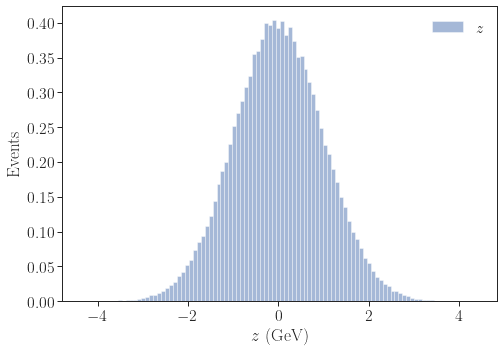

In [13]:
# Latent distribution
n_samples = 100000
z_gen = torch.randn((n_samples, n_dim))

print(z_gen.shape)

# Visualize the latent distribution
fig, axs = plt.subplots(figsize=(7,5))

axs.hist(z_gen.detach().numpy().flatten(), alpha=0.5, density=True, bins=100, label=r'$z$')

axs.set_xlabel('$z$ $(\mathrm{GeV})$')
axs.set_ylabel( r'$\mathrm{Events}$' )
axs.legend(loc='best', frameon=False)

fig.tight_layout()

In [15]:
# Generate m2 samples from latent distribution
mp_thetap_gen, _ = model(z_gen, rev=True)
mp_thetap_gen = mp_thetap_gen.detach().numpy()[:]

print(mp_thetap_gen.shape)
print(mp_thetap_gen[0])

(100000, 2)
[0.15261209 0.7676098 ]


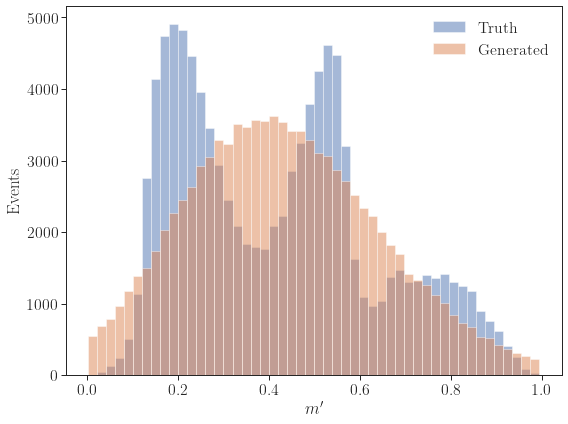

In [16]:
# Visualize 
fig, ax = plt.subplots( figsize=(8,6) )

counts, bins, _ = ax.hist(mp_thetap[:n_samples,0], 50, alpha = 0.5, label = r'$\mathrm{Truth}$')
ax.hist(mp_thetap_gen[:,0], bins, alpha=0.5, label = r'$\mathrm{Generated}$')

ax.set_xlabel( r"$m'$")
ax.set_ylabel( r'$\mathrm{Events}$' )


ax.legend(loc='best', frameon=False)

fig.tight_layout()

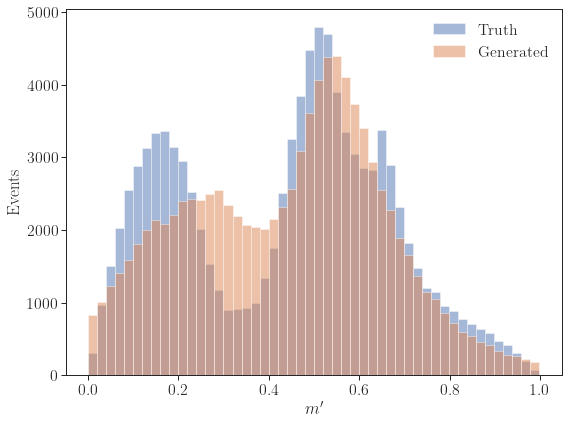

In [17]:
# Visualize 
fig, ax = plt.subplots( figsize=(8,6) )

counts, bins, _ = ax.hist(mp_thetap[:n_samples,1], 50, alpha = 0.5, label = r'$\mathrm{Truth}$')
ax.hist(mp_thetap_gen[:,1], bins, alpha=0.5, label = r'$\mathrm{Generated}$')

ax.set_xlabel( r"$m'$")
ax.set_ylabel( r'$\mathrm{Events}$' )


ax.legend(loc='best', frameon=False)

fig.tight_layout()